<a href="https://colab.research.google.com/github/liuxx479/kappaTNG/blob/master/kappaTNG_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from pylab import *
import os
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.special import factorial
from matplotlib.gridspec import GridSpec
from scipy.interpolate import splev, splrep
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root = '/content/drive/My Drive/kappaTNG/'
zs = np.genfromtxt(root+'zs.dat')

In [4]:
######## parameters

# LCDM parameters
A_s = 2.142e-9
h=0.6774
OmegaB = 0.0486
OmegaM = 0.3089
n_s = 0.9667

### derived parameters
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100

### accuracy parameters
lmax=10000

In [5]:
############# fitting formula from Ken
zs2,  ls1,  ls2,  a1,  a2 = np.genfromtxt(root+'fitted_params_osato.txt', usecols=range(1,6)).T
ratio_osato_fun = lambda i: (1+(ell/ls1[i])**a1[i]) / (1+(ell/ls2[i])**a2[i])

[ 101.8234  144.      160.9969  218.7537  284.3995  359.3011  446.1363
  562.7012  713.0505  892.3582 1056.544  1192.623  1335.852  1497.288
 1681.971  1888.175  2119.545  2377.31   2668.762  2993.712  3359.343 ]


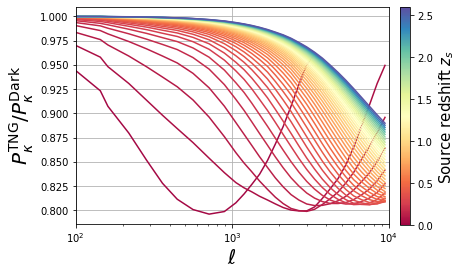

In [6]:
######### plot_ratio_all

# plt.rc("text", usetex=True)
# plt.rc("xtick", labelsize=12)
# plt.rc("ytick", labelsize=12)


fig = plt.figure(figsize=(6,4))
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)


for i in range(1, 41):
    d = np.loadtxt(root+"data/output/spec/ratio{:02d}.dat".format(i))
    if i == 1:
        ell = d[:21, 0]
        ratio = d[:21, 1]
        print(ell)
    else:
        ell = d[:, 0]
        ratio = d[:, 1]
    plt.plot(ell, ratio, c=cmap(norm(zs[i-1])))

plt.xscale('log')
plt.xlim(1e2, 1e4)
plt.xlabel(r'$\ell$', fontsize=20)
# plt.ylabel(r'$R (\ell)$', fontsize=15)
plt.ylabel(r'$P_\kappa^{\rm TNG}/P_\kappa^{\rm Dark}$', fontsize=20)

plt.grid()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.savefig(root+"figures/ratio_all.pdf", bbox_inches='tight')
plt.show()


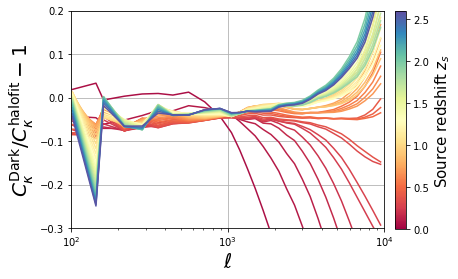

In [7]:
######### halofit comparison

from scipy.interpolate import interp1d

fig = plt.figure(figsize=(6,4))
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)


for i in range(2, 41):

    d = np.loadtxt(root+"data/output_dark/spec/power{:02d}.dat".format(i))
    ell = d[:, 0]
    prefac = ell*(ell+1.0)/(2.0*np.pi)
    Dlk_Dark = prefac*d[:, 6]

    d = np.loadtxt(root+"data/output_theory/TNG_halofit_{}_cl.dat".format(i))
    # d = np.loadtxt(root+"data/output_theory/TNG_HMcode_emu_{}_cl.dat".format(i))
    # d = np.loadtxt(root+"data/output_theory/TNG_HMcode_dmonly_{}_cl.dat".format(i))
    ell_theory = d[:, 0]
    sCl = d[:, 1]
    Dlk_theory = 1.0/4.0*(ell_theory*(ell_theory+1.0))**2*sCl
    Dlk_theory_interp = interp1d(ell_theory, Dlk_theory)(ell)
    plt.plot(ell, Dlk_Dark/Dlk_theory_interp-1, ls='-', c=cmap(norm(zs[i-1])))

    # spl = splrep(ell_theory, Dlk_theory)
    # plt.plot(ell, Dlk_Dark/splev(ell, spl), ls='-', c=cmap(norm(zs[i-1])))

plt.xscale('log')
plt.xlim(1e2, 1e4)
plt.ylim(-0.3, 0.2)
plt.xlabel(r'$\ell$', fontsize=20)
# plt.ylabel(r'$R (\ell)$', fontsize=15)
plt.ylabel(r'$C_\kappa^{\rm Dark}/C_\kappa^{\rm halofit}-1$', fontsize=20)

plt.grid()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.savefig(root+"figures/power_halofit.pdf", bbox_inches='tight')
# plt.savefig(root+"figures/power_HMcode.pdf", bbox_inches='tight')
plt.show()


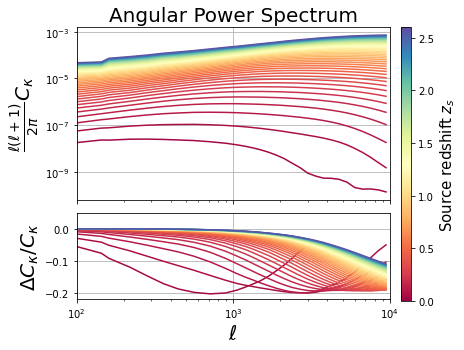

In [8]:
######### power spectrum

fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

for i in range(40):
  dps = np.loadtxt(root+"data/output/spec/power{:02d}.dat".format(i+1)).T
  dpsratio = np.loadtxt(root+"data/output/spec/ratio{:02d}.dat".format(i+1)).T
  ell, ips, ipsratio = dps[0], dps[6], dpsratio[1]

  ax0.plot(ell, ips*ell*(1+ell)/2/pi, c=cmap(norm(zs[i])))
  if i==0:
    ax1.plot(ell[:21], ipsratio[:21]-1, c=cmap(norm(zs[i])))
  else:
    ax1.plot(ell, ipsratio-1, c=cmap(norm(zs[i])))


ax0.grid()
ax0.set_xlim(1e2, 1e4)
ax0.set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi} C_\kappa$', fontsize=20)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xticklabels([])

ax1.set_xscale('log')
ax1.set_xlim(1e2, 1e4)
ax1.set_ylim(0.78-1, 1.05-1)
ax1.grid()
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$\Delta C_{\kappa}/C_{\kappa}$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

ax0.set_title(r'Angular Power Spectrum', fontsize=20)
# plt.savefig(root+"figures/PS_all.pdf", bbox_inches='tight')
plt.show()

In [9]:
d = np.array([np.loadtxt(root+"data/output/peaks/sm_2arcmin/pm{:02d}.dat".format(i)) for i in range(1,41)])
d_diff = np.array([np.loadtxt(root+"data/output/peaks/sm_2arcmin/diff{:02d}.dat".format(i)) for i in range(1,41)])
#nu peaks std minima std PDF std kappa2 std
print (d.shape)

(40, 300, 9)


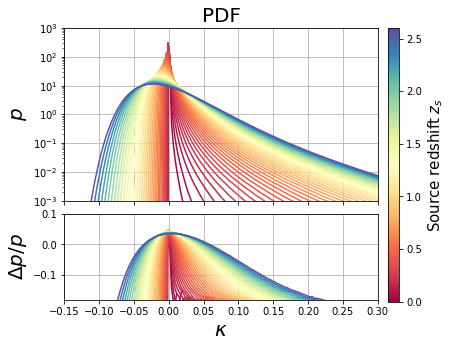

In [10]:
######### pdf

fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

kappa = d[0,:,0]

for i in range(40):
  iy, iystd, iydiff = d[i, :, 5], d[i, :, 6], d_diff[i, :, 5]
  idx=np.where(iy>1e-2)
  ax0.plot(kappa, iy, c=cmap(norm(zs[i])))
  ax1.plot(kappa[idx], iydiff[idx]/iy[idx], c=cmap(norm(zs[i])))


ax0.set_yscale('log')
ax0.set_xlim(-0.15, 0.3)
ax0.set_ylim(1e-3, 1e3)
ax0.set_xticklabels([])
ax0.grid()
ax0.set_ylabel(r'$p$', fontsize=20)


ax1.set_xlim(-0.15, 0.3)
ax1.set_ylim(-0.18, 0.1)
ax1.grid()
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta p/p$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

ax0.set_title(r'PDF', fontsize=20)
# plt.savefig(root+"figures/PDF_all.pdf", bbox_inches='tight')
plt.show()

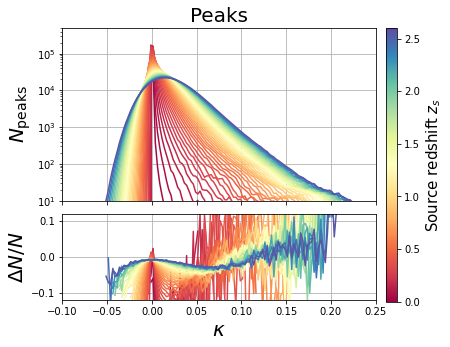

In [11]:
######## peaks
fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

kappa = d[0,:,0]

for i in range(40):
  iy, iystd, iydiff = d[i, :, 1], d[i, :, 2], d_diff[i, :, 1]
  idx=np.where(iy>10)
  ax0.plot(kappa, iy, c=cmap(norm(zs[i])))
  ax1.plot(kappa[idx], iydiff[idx]/iy[idx], c=cmap(norm(zs[i])))

ax0.set_yscale('log')
ax0.set_xlim(-0.1, 0.25)
ax0.set_ylim(10, 5e5)
ax0.set_xticklabels([])
ax0.grid()
ax0.set_ylabel(r'$N_{\rm peaks}$', fontsize=20)


ax1.set_xlim(-0.1, 0.25)
ax1.set_ylim(-0.12, 0.12)
ax1.grid()
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta N/N$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()
ax0.set_title(r'Peaks', fontsize=20)
# plt.savefig(root+"figures/Peaks_all.pdf", bbox_inches='tight')

plt.show()

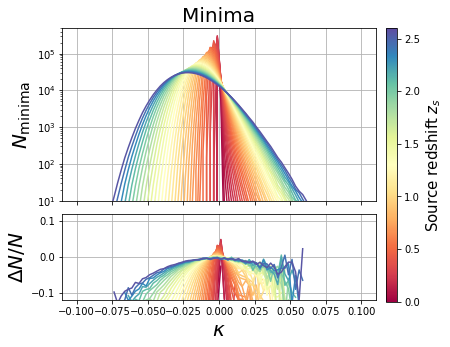

In [12]:
######## minima
fig = plt.figure(figsize=(6,5))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[2, 1], hspace=0.1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cmap = mpl.cm.get_cmap('Spectral')
norm = mpl.colors.Normalize(vmin=0.0, vmax=2.6)

kappa = d[0,:,0]

for i in range(40):
  iy, iystd, iydiff = d[i, :, 3], d[i, :, 4], d_diff[i, :, 3]
  idx=np.where(iy>10)
  ax0.plot(kappa, iy, c=cmap(norm(zs[i])))
  ax1.plot(kappa[idx], iydiff[idx]/iy[idx], c=cmap(norm(zs[i])))



# ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim(-0.11, 0.11)
ax0.set_ylim(10, 5e5)
ax0.set_xticklabels([])
ax0.grid()
ax0.set_ylabel(r'$N_{\rm minima}$', fontsize=20)


ax1.set_xlim(-0.11, 0.11)
ax1.set_ylim(-0.12, 0.12)
ax1.grid()
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta N/N$', fontsize=20)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.875, 0.12, 0.025, 0.76])

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label(r"Source redshift $z_s$", fontsize=15)

# plt.tight_layout()
ax0.set_title(r'Minima', fontsize=20)
# plt.savefig(root+"figures/Minima_all.pdf", bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/li

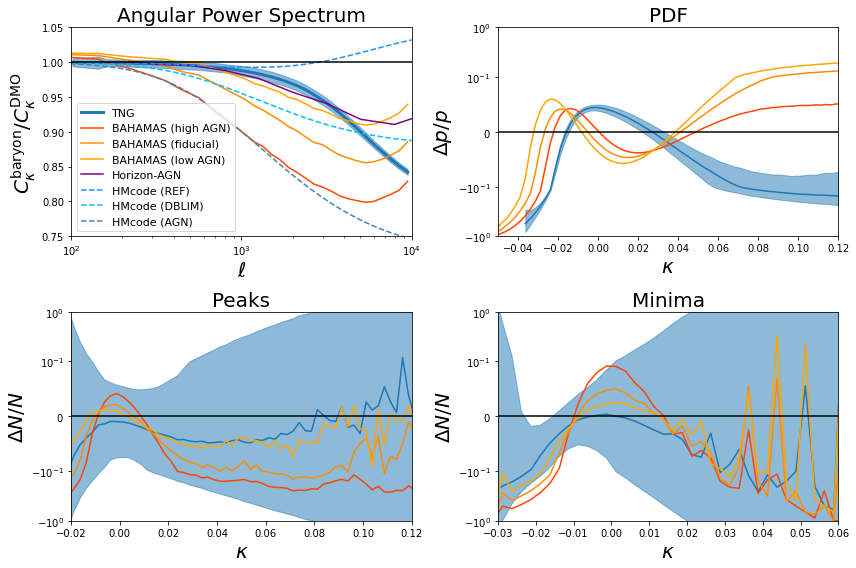

In [66]:
############ comparison to theory and other sims

fig = plt.figure(figsize=(12,8))

ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

######## ps

i = 23

ell, ratio, ratio_s  = np.loadtxt(root+"data/output/spec/ratio{:02d}.dat".format(i)).T
ax0.plot(ell, ratio, lw=3, c="C0", label="TNG")
ax0. fill_between(ell, ratio-ratio_s, ratio+ratio_s, color="C0", alpha=0.5)

ell, ratio, ratio_s  = np.loadtxt(root+"data/output_BAHAMAS/hi_AGN/spec/ratio.dat").T
ax0.plot(ell, ratio, c="orangered", label="BAHAMAS (high AGN)")

ell, ratio, ratio_s  = np.loadtxt(root+"data/output_BAHAMAS/fiducial/spec/ratio.dat").T
ax0.plot(ell, ratio, c="darkorange", label="BAHAMAS (fiducial)")

ell, ratio, ratio_s  = np.loadtxt(root+"data/output_BAHAMAS/low_AGN/spec/ratio.dat").T
ax0.plot(ell, ratio, c="orange", label="BAHAMAS (low AGN)")

ell, ratio = np.loadtxt(root+"data/Gouin19_ratio.dat").T
ax0.plot(ell, ratio, c="purple", label="Horizon-AGN")

ell_HMcode,sCl_emu = np.loadtxt(root+"data/output_theory/TNG_HMcode_dmonly_{}_cl.dat".format(i)).T
ell_HMcode,sCl_ref = np.loadtxt(root+"data/output_theory/TNG_HMcode_ref_{}_cl.dat".format(i)).T
ell_HMcode,sCl_dblim = np.loadtxt(root+"data/output_theory/TNG_HMcode_dblim_{}_cl.dat".format(i)).T
ell_HMcode, sCl_agn = np.loadtxt(root+"data/output_theory/TNG_HMcode_agn_{}_cl.dat".format(i)).T
ax0.plot(ell_HMcode, sCl_ref/sCl_emu, c="dodgerblue", ls="--", label="HMcode (REF)")
ax0.plot(ell_HMcode, sCl_dblim/sCl_emu, c="deepskyblue", ls="--", label="HMcode (DBLIM)")
ax0.plot(ell_HMcode, sCl_agn/sCl_emu, c="steelblue", ls="--", label="HMcode (AGN)")

x = np.logspace(1.0, 4.0, 100)
y = np.ones_like(x)
ax0.plot(x, y, c="k")
ax0.set_title(r'Angular Power Spectrum', fontsize=20)

# d = np.loadtxt("fitting_parameters.dat")
# ell_s1 = d[i-1, 1]
# ell_s2 = d[i-1, 2]
# alpha1 = d[i-1, 3]
# alpha2 = d[i-1, 4]
# ax0.plot(ell_HMcode, func_C(ell_HMcode, ell_s1, ell_s2, alpha1, alpha2),
        #  c="C8", ls="-.", label=r"Fitting formula")


ax0.set_xscale('log')
ax0.set_xlim(1e2, 1e4)
ax0.set_ylim(0.75, 1.05)
# ax0.grid()
ax0.set_xlabel(r'$\ell$', fontsize=20)
ax0.set_ylabel(r'$C_{\kappa}^{\rm baryon}/C_{\kappa}^{\rm DMO}$', fontsize=20)
ax0.legend(fontsize=11)


########## PDF

def find_std (nu, pdf): #https://blogs.ubc.ca/math105/continuous-random-variables/expected-value-variance-standard-deviation/
  nu_mean = sum(nu*pdf)/sum(pdf)
  var = sum((nu-nu_mean)**2 * pdf) / sum(pdf)
  return sqrt(var) 

# d = np.loadtxt(root+"data/output_theory/kappa0.dat")
# kappa0 = d[i-1, 1]

d = np.loadtxt(root+"data/output/PDF/pm{:02d}.dat".format(i))
nu = d[:, 0]
PDF = d[:, 5]

# for nui, PDFi in zip(nu, PDF):
#     if nui < 0.0:
#         continue
#     if PDFi < 1e-6:
#         right = nui
#         break

d = np.loadtxt(root+"data/output/PDF/diff{:02d}.dat".format(i))
nu = d[:, 0]
PDFd = d[:, 5]
PDFd_e = d[:, 6]

d = np.loadtxt(root+"data/output_dark/PDF/pm{:02d}.dat".format(i))
PDF_dark = d[:, 5]

####### rescale the PDF
# istd = find_std(nu, PDF)
# nu/=istd
# print (istd)

idx=np.where(PDF_dark>1e-2)
ax1.plot(nu[idx], PDFd[idx]/PDF_dark[idx], c="C0", label="TNG")
ax1.fill_between(nu[idx], (PDFd[idx]-PDFd_e[idx])/PDF_dark[idx], (PDFd[idx]+PDFd_e[idx])/PDF_dark[idx], color="C0", alpha=0.5)


d = np.loadtxt(root+"data/output_BAHAMAS/DMONLY/PDF/pm.dat")
PDF_dark = d[:, 5]


d = np.loadtxt(root+"data/output_BAHAMAS/hi_AGN/PDF/diff.dat")
nu = d[:, 0]
PDFd = d[:, 5]
PDFd_e = d[:, 6]
# istd = find_std(nu, PDF_dark)
# print (istd)
# nu/=istd
ax1.plot(nu, PDFd/PDF_dark, c="orangered", label="BAHAMAS (high AGN)")

d = np.loadtxt(root+"data/output_BAHAMAS/fiducial/PDF/diff.dat")
# nu = d[:, 0]
PDFd = d[:, 5]
PDFd_e = d[:, 6]
ax1.plot(nu, PDFd/PDF_dark, c="darkorange", label="BAHAMAS (fiducial)")
# 
d = np.loadtxt(root+"data/output_BAHAMAS/low_AGN/PDF/diff.dat")
# nu = d[:, 0]
PDFd = d[:, 5]
PDFd_e = d[:, 6]
ax1.plot(nu, PDFd/PDF_dark, c="orange", label="BAHAMAS (low AGN)")

ax1.plot([-1,1], [0,0], c="k")

ax1.set_yscale('symlog', linthreshy=0.1)
ax1.set_xlim(-0.05, 0.12)
ax1.set_ylim(-1, 1)
# ax1.set_ylim(-0.3, 0.3)
ax1.set_xlabel(r'$\kappa$', fontsize=20)
ax1.set_ylabel(r'$\Delta p / p$', fontsize=20)
# ax1.legend(fontsize=12)
ax1.set_title(r'PDF', fontsize=20)

############# peaks
sm_id = 1
sm = ["sm_1arcmin", "sm_2arcmin", "sm_5arcmin"]
theta_sm = [1, 2, 5]
thres = [1.0, 1.0, 0.1]
Omega = [24.22485, 23.65150, 21.60797]

# ax0.set_title("$z_s = {:.5f}$".format(zs[i-1]), fontsize=15)

d = np.loadtxt(root+"data/output/peaks/"+sm[sm_id]+"/pm{:02d}.dat".format(i))

nu = d[:, 0]
peaks = d[:, 1]/Omega[sm_id]
peaks_e = d[:, 2]/Omega[sm_id]

d = np.loadtxt(root+"data/output/peaks/"+sm[sm_id]+"/diff{:02d}.dat".format(i))
nu = d[:, 0]
peaksd = d[:, 1]
peaksd_e = d[:, 2]

d = np.loadtxt(root+"data/output_dark/peaks/"+sm[sm_id]+"/pm{:02d}.dat".format(i))
peaks_dark = d[:, 1]
ax2.plot(nu, peaksd/peaks_dark, c="C0", label="TNG")
ax2.fill_between(nu, (peaksd-peaksd_e)/peaks_dark, (peaksd+peaksd_e)/peaks_dark,
                 color="C0", alpha=0.5)


d = np.loadtxt(root+"data/output_BAHAMAS/DMONLY/peaks/"+sm[sm_id]+"/pm.dat")
peaks_dark = d[:, 1]

d = np.loadtxt(root+"data/output_BAHAMAS/hi_AGN/peaks/"+sm[sm_id]+"/diff.dat")
nu = d[:, 0]
peaksd = d[:, 1]
peaksd_e = d[:, 2]
ax2.plot(nu, peaksd/peaks_dark, c="orangered", label="BAHAMAS (high AGN)")

d = np.loadtxt(root+"data/output_BAHAMAS/fiducial/peaks/"+sm[sm_id]+"/diff.dat")
nu = d[:, 0]
peaksd = d[:, 1]
peaksd_e = d[:, 2]
ax2.plot(nu, peaksd/peaks_dark, c="darkorange", label="BAHAMAS (fiducial)")

d = np.loadtxt(root+"data/output_BAHAMAS/low_AGN/peaks/"+sm[sm_id]+"/diff.dat")
nu = d[:, 0]
peaksd = d[:, 1]
peaksd_e = d[:, 2]
ax2.plot(nu, peaksd/peaks_dark, c="orange", label="BAHAMAS (low AGN)")

ax2.plot([-1,1], [0,0], c="k")
ax2.set_yscale('symlog', linthreshy=0.1)
ax2.set_xlim(-0.02, 0.12)
ax2.set_ylim(-1, 1)
ax2.set_xlabel(r'$\kappa$', fontsize=20)
ax2.set_ylabel(r'$\Delta N/N$', fontsize=20)
# ax2.legend(fontsize=12)
ax2.set_title(r"Peaks", fontsize=20)


############# minima
sm_id = 1
sm = ["sm_1arcmin", "sm_2arcmin", "sm_5arcmin"]
theta_sm = [1, 2, 5]
thres = [1.0, 1.0, 0.1]
Omega = [24.22485, 23.65150, 21.60797]

# ax0.set_title("$z_s = {:.5f}$".format(zs[i-1]), fontsize=15)

d = np.loadtxt(root+"data/output/minima/"+sm[sm_id]+"/pm{:02d}.dat".format(i))

nu = d[:, 0]
minima = d[:, 3]/Omega[sm_id]
minima_e = d[:, 4]/Omega[sm_id]

d = np.loadtxt(root+"data/output/minima/"+sm[sm_id]+"/diff{:02d}.dat".format(i))
nu = d[:, 0]
minimad = d[:, 3]
minimad_e = d[:, 4]

d = np.loadtxt(root+"data/output_dark/minima/"+sm[sm_id]+"/pm{:02d}.dat".format(i))
minima_dark = d[:, 3]
ax3.plot(nu, minimad/minima_dark, c="C0", label="TNG")
ax3.fill_between(nu, (minimad-minimad_e)/minima_dark, (minimad+minimad_e)/minima_dark,
                 color="C0", alpha=0.5)


d = np.loadtxt(root+"data/output_BAHAMAS/DMONLY/minima/"+sm[sm_id]+"/pm.dat")
minima_dark = d[:, 3]

d = np.loadtxt(root+"data/output_BAHAMAS/hi_AGN/minima/"+sm[sm_id]+"/diff.dat")
nu = d[:, 0]
minimad = d[:, 3]
minimad_e = d[:, 4]
ax3.plot(nu, minimad/minima_dark, c="orangered", label="BAHAMAS (high AGN)")

d = np.loadtxt(root+"data/output_BAHAMAS/fiducial/minima/"+sm[sm_id]+"/diff.dat")
nu = d[:, 0]
minimad = d[:, 3]
minimad_e = d[:, 4]
ax3.plot(nu, minimad/minima_dark, c="darkorange", label="BAHAMAS (fiducial)")

d = np.loadtxt(root+"data/output_BAHAMAS/low_AGN/minima/"+sm[sm_id]+"/diff.dat")
nu = d[:, 0]
minimad = d[:, 3]
minimad_e = d[:, 4]
ax3.plot(nu, minimad/minima_dark, c="orange", label="BAHAMAS (low AGN)")

ax3.plot([-1,1], [0,0], c="k")
ax3.set_yscale('symlog', linthreshy=0.1)
ax3.set_xlim(-0.03, 0.06)
ax3.set_ylim(-1, 1)
ax3.set_xlabel(r'$\kappa$', fontsize=20)
ax3.set_ylabel(r'$\Delta N/N$', fontsize=20)
# ax3.legend(fontsize=12)
ax3.set_title(r"Minima", fontsize=20)

#############

plt.tight_layout()
plt.savefig(root+"figures/Comparison_all.pdf", bbox_inches='tight')
plt.show()